In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [43]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=70

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 3 0 2 2 0 0 1 1 3 0 3 0 0 1 2 1 1 0 2 3 1 3 3 2 3 2 0 0 1 0 3]


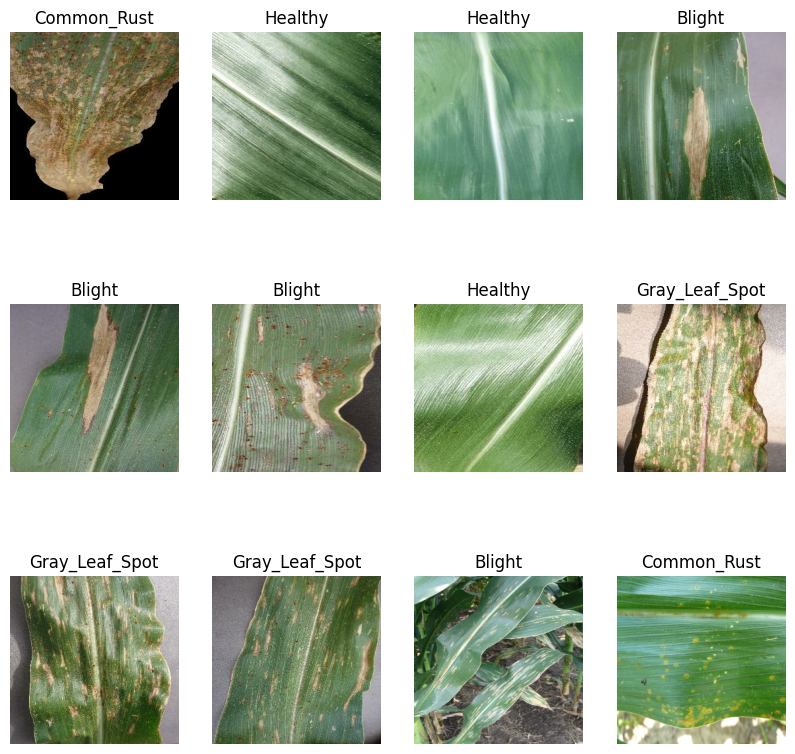

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

131

In [8]:
train_size = 0.8
len(dataset)*train_size

104.80000000000001

In [9]:
train_ds = dataset.take(104)
len(train_ds)

104

In [10]:
test_ds = dataset.skip(104)
len(test_ds)

27

In [11]:
val_size=0.1
len(dataset)*val_size

13.100000000000001

In [12]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [13]:
test_ds = test_ds.skip(13)
len(test_ds)

14

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

104

In [17]:
len(val_ds)

13

In [18]:
len(test_ds)

14

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)

Epoch 1/70
104/104 [==============================] - 933s 9s/step - loss: 0.1731 - accuracy: 0.9293 - val_loss: 0.1642 - val_accuracy: 0.9351
Epoch 2/70
104/104 [==============================] - 464s 4s/step - loss: 0.1898 - accuracy: 0.9254 - val_loss: 0.1456 - val_accuracy: 0.9375
Epoch 3/70
104/104 [==============================] - 437s 4s/step - loss: 0.1673 - accuracy: 0.9326 - val_loss: 0.1559 - val_accuracy: 0.9447
Epoch 4/70
104/104 [==============================] - 420s 4s/step - loss: 0.1652 - accuracy: 0.9347 - val_loss: 0.1391 - val_accuracy: 0.9399
Epoch 5/70
104/104 [==============================] - 447s 4s/step - loss: 0.1695 - accuracy: 0.9290 - val_loss: 0.1822 - val_accuracy: 0.9303
Epoch 6/70
104/104 [==============================] - 454s 4s/step - loss: 0.1736 - accuracy: 0.9365 - val_loss: 0.1450 - val_accuracy: 0.9399
Epoch 7/70
104/104 [==============================] - 430s 4s/step - loss: 0.1573 - accuracy: 0.9383 - val_loss: 0.1454 - val_accuracy: 0.9375

In [29]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 58s 4s/step - loss: 0.1818 - accuracy: 0.9330


In [30]:
scores

[0.18181653320789337, 0.9330357313156128]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 104}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

70

In [36]:
history.history['loss'][:5]

[0.1730944663286209,
 0.18980824947357178,
 0.16725200414657593,
 0.16519378125667572,
 0.169510155916214]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [38]:
val_acc

[0.9350961446762085,
 0.9375,
 0.9447115659713745,
 0.9399038553237915,
 0.9302884340286255,
 0.9399038553237915,
 0.9375,
 0.9375,
 0.9375,
 0.9302884340286255,
 0.942307710647583,
 0.9495192170143127,
 0.9495192170143127,
 0.9158653616905212,
 0.9471153616905212,
 0.9447115659713745,
 0.9495192170143127,
 0.9447115659713745,
 0.9663461446762085,
 0.932692289352417,
 0.9495192170143127,
 0.9302884340286255,
 0.9447115659713745,
 0.9302884340286255,
 0.9375,
 0.9543269276618958,
 0.9543269276618958,
 0.9495192170143127,
 0.963942289352417,
 0.96875,
 0.9471153616905212,
 0.9495192170143127,
 0.9399038553237915,
 0.9495192170143127,
 0.9591346383094788,
 0.9399038553237915,
 0.9711538553237915,
 0.9567307829856873,
 0.9495192170143127,
 0.9591346383094788,
 0.9663461446762085,
 0.942307710647583,
 0.9543269276618958,
 0.9519230723381042,
 0.9519230723381042,
 0.9519230723381042,
 0.9471153616905212,
 0.9663461446762085,
 0.9567307829856873,
 0.96875,
 0.942307710647583,
 0.9735577106475

In [39]:
acc

[0.9293020367622375,
 0.9253910779953003,
 0.9326112866401672,
 0.9347172379493713,
 0.9290012121200562,
 0.9365222454071045,
 0.9383273124694824,
 0.9241877198219299,
 0.9338147044181824,
 0.9362214207649231,
 0.938026487827301,
 0.9416365623474121,
 0.9395306706428528,
 0.9329121708869934,
 0.9335138201713562,
 0.9410349130630493,
 0.9431408047676086,
 0.9271961450576782,
 0.939831554889679,
 0.945246696472168,
 0.949759304523468,
 0.939831554889679,
 0.9377256035804749,
 0.9464500546455383,
 0.9386281371116638,
 0.9440433382987976,
 0.94344162940979,
 0.9461492300033569,
 0.9512635469436646,
 0.9473525881767273,
 0.9542719721794128,
 0.9446449875831604,
 0.9479542970657349,
 0.9467508792877197,
 0.9458483457565308,
 0.9548736214637756,
 0.9536702632904053,
 0.9554753303527832,
 0.9500601887702942,
 0.9545727968215942,
 0.9551745057106018,
 0.9491576552391052,
 0.9527677297592163,
 0.9536702632904053,
 0.9527677297592163,
 0.9518651962280273,
 0.9572803974151611,
 0.9593862891197205,

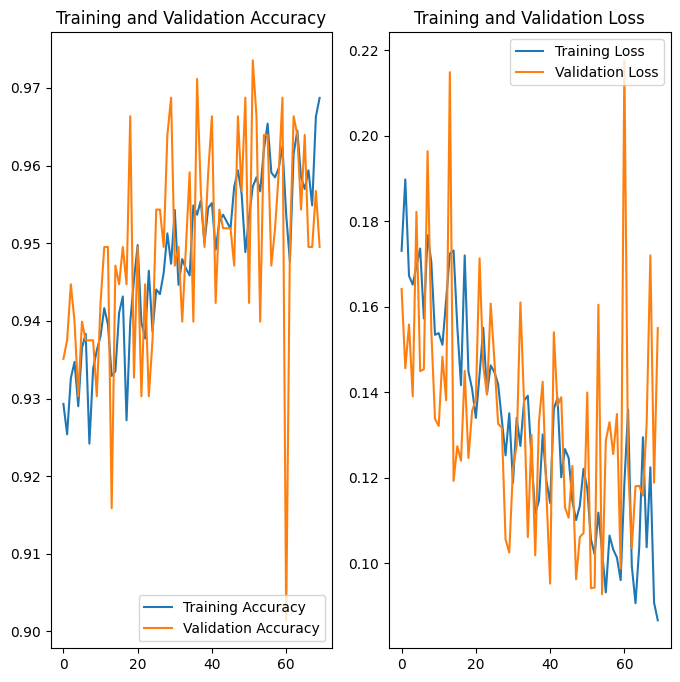

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blight
1/1 [==============================] - 4s 4s/step
predicted label: Blight


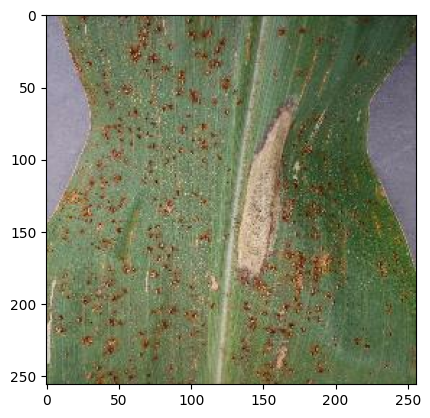

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 79ms/step


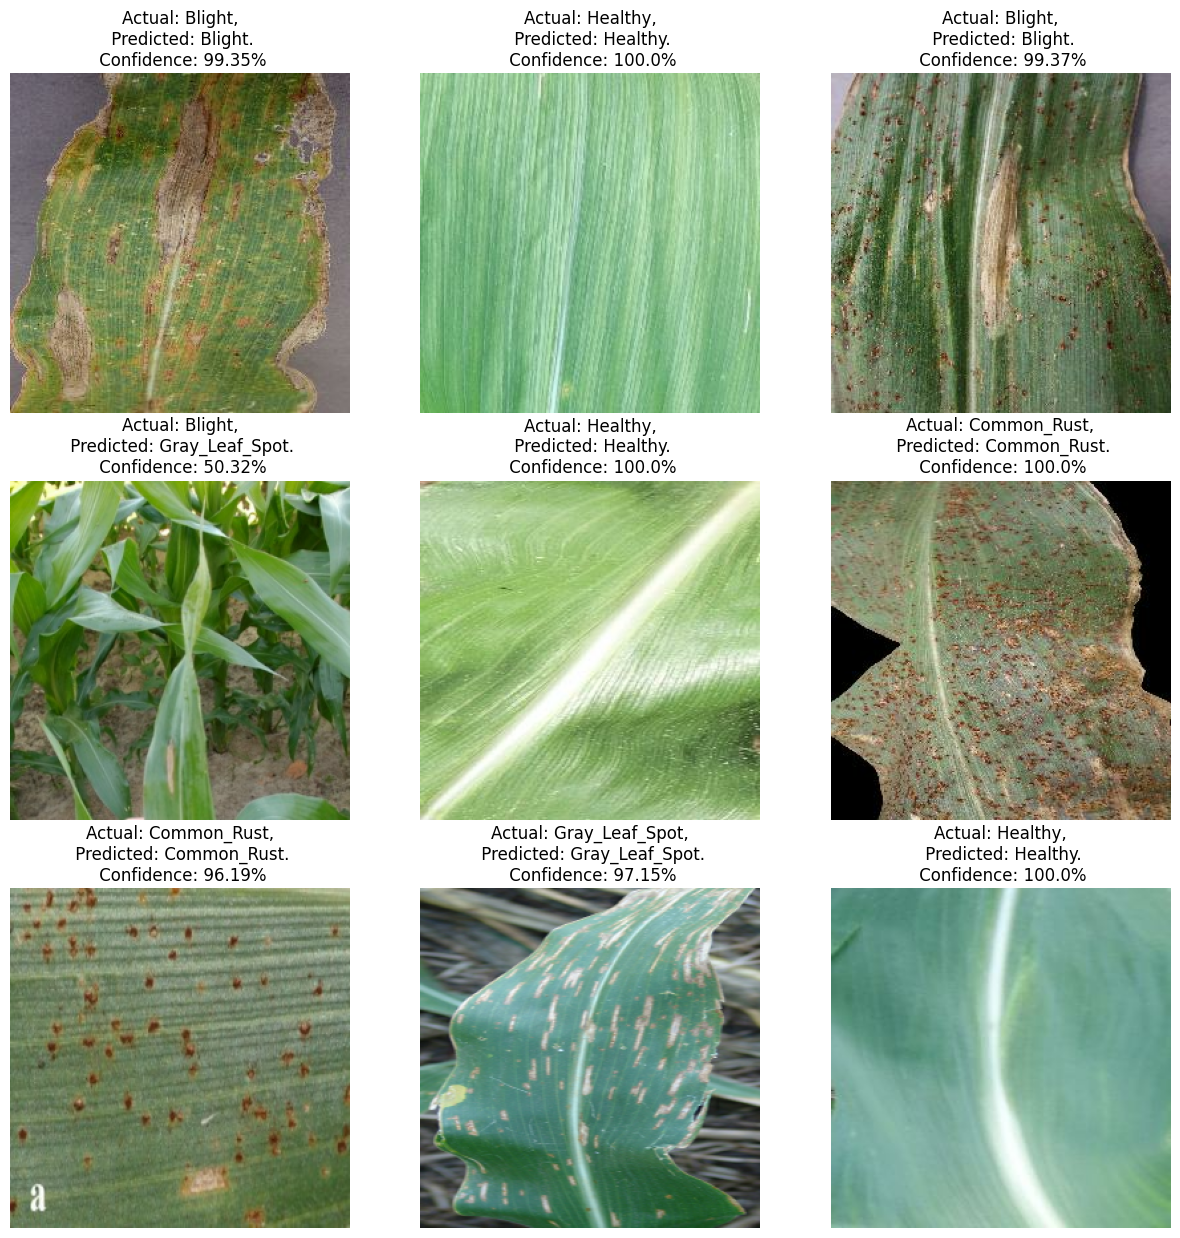

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
